### CAPSTONE PROJECT



In this Capstone we will be doing a timeseries analysis of GDP.GDP (Gross Domestic Product) is the total monetary value of all goods and services produced within a country over a specific period. It reflects the economic health and productivity of a nation.
GDP Equation (Expenditure Approach):

GDP = 
𝐶
+
𝐼
+
𝐺
+
(
𝑋
−
𝑀
)
GDP=C+I+G+(X−M)
Where:

C = Consumption (household spending)

I = Investment (business spending on capital)

G = Government spending

X = Exports

M = Imports

(X − M) = Net exports

Types of GDP:
Nominal GDP – Measures output using current prices (includes inflation).

Real GDP – Adjusted for inflation, showing true growth over time.

In [1]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import json
import datetime
from prophet import Prophet



c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# World Bank API endpoint for Real GDP (constant 2015 US$)
url = 'http://api.worldbank.org/v2/country/KE/indicator/NY.GDP.MKTP.KD?format=json&per_page=1000'

# Request and extract data
response = requests.get(url)
records = response.json()[1]

# Convert to DataFramme
df = pd.DataFrame(records)[['date', 'value']]
df.columns = ['Year', 'Real_GDP']
df.dropna(inplace=True)

# Convert to datetime and set index
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)
df.sort_index(inplace=True)

# Preview the result
display(df)


,Real_GDP
Year,
1960-01-01,6.102055e+09
1961-01-01,5.627643e+09
1962-01-01,6.159869e+09
1963-01-01,6.700604e+09
1964-01-01,7.033253e+09
...,...
2019-01-01,8.426498e+10
2020-01-01,8.403514e+10
2021-01-01,9.041382e+10


###  Exploratory Data Analysis (EDA)

In [3]:
df.describe()

,Real_GDP
count,6.400000e+01
mean,3.567972e+10
std,2.512398e+10
min,5.627643e+09
25%,1.528157e+10
50%,3.067695e+10
75%,4.985316e+10
max,1.000753e+11


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64 entries, 1960-01-01 to 2023-01-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Real_GDP  64 non-null     float64
dtypes: float64(1)
memory usage: 1.0 KB


## Visualizations 

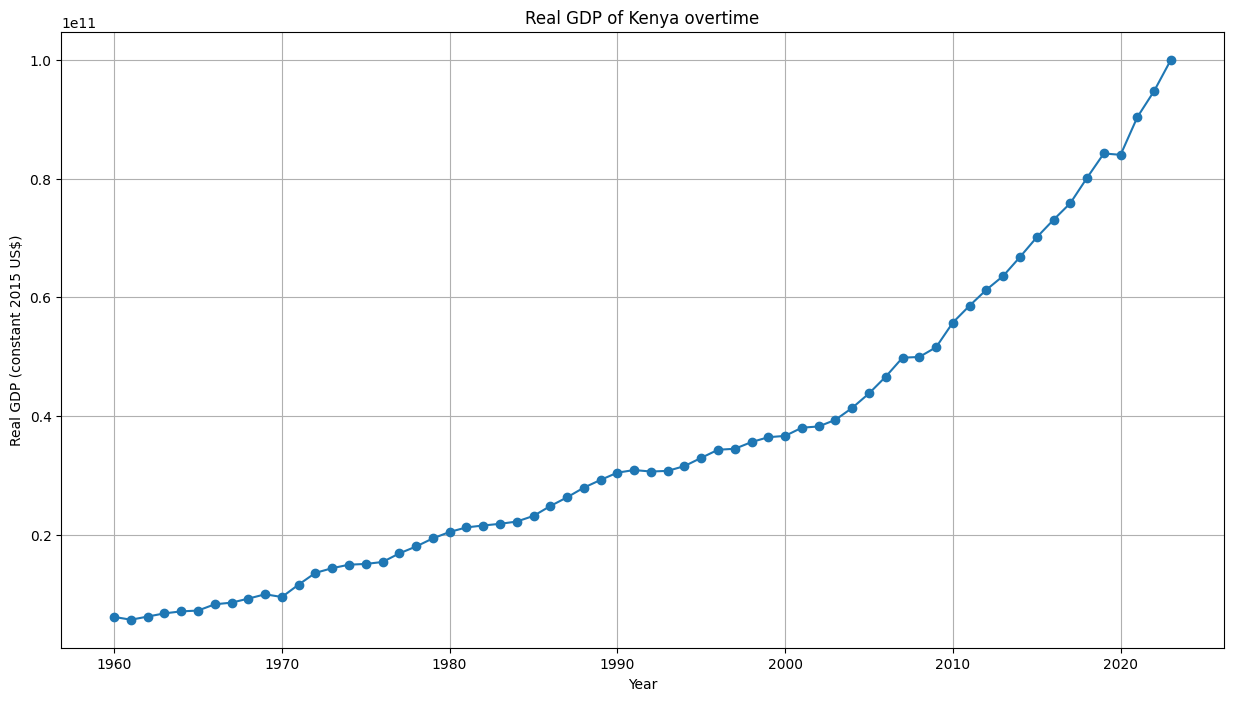

In [5]:
# Ploting the GDP of Kenya  over the years  
plt.figure(figsize=(15, 8))
plt.plot(df['Real_GDP'], marker='o')
plt.title('Real GDP of Kenya overtime')
plt.xlabel('Year')
plt.ylabel('Real GDP (constant 2015 US$)')
plt.grid()

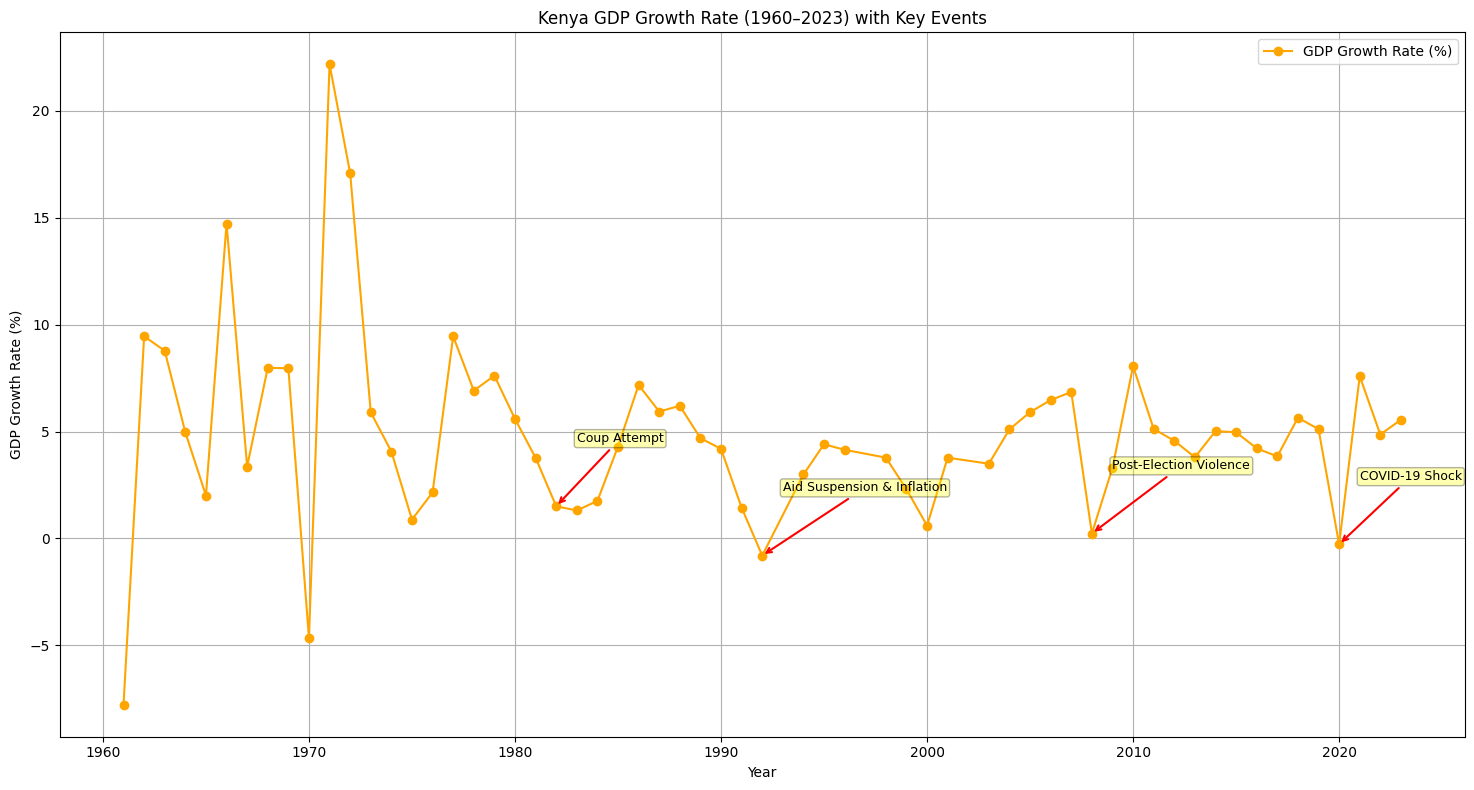

In [ ]:

# Convert DateTime index to year integers (if needed)
df.index = df.index.year

# Remove specific years
df = df[~df.index.isin([1993, 1997, 2002])]

# Recalculate GDP growth rate
df['GDP Growth Rate (%)'] = df['Real_GDP'].pct_change() * 100

# Create the plot
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['GDP Growth Rate (%)'], marker='o', color='orange', label='GDP Growth Rate (%)')
plt.title('Kenya GDP Growth Rate (1960–2023) with Key Events')
plt.xlabel('Year')
plt.ylabel('GDP Growth Rate (%)')
plt.grid(True)

# Key events to annotate
annotations = {
    1982: "Coup Attempt",
    1992: "Aid Suspension & Inflation",
    2008: "Post-Election Violence",
    2020: "COVID-19 Shock"
}

# Add arrow annotations
for year, label in annotations.items():
    if year in df.index:
        y = df.loc[year, 'GDP Growth Rate (%)']
        plt.annotate(
            label,
            xy=(year, y),
            xytext=(year + 1, y + 3),  # Offset the label
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
            fontsize=9,
            color='black',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3)
        )

plt.legend()
plt.tight_layout()
plt.show()


In [7]:
df['Rolling GDP (5yr avg)'] = df['Real_GDP'].rolling(window=5).mean()

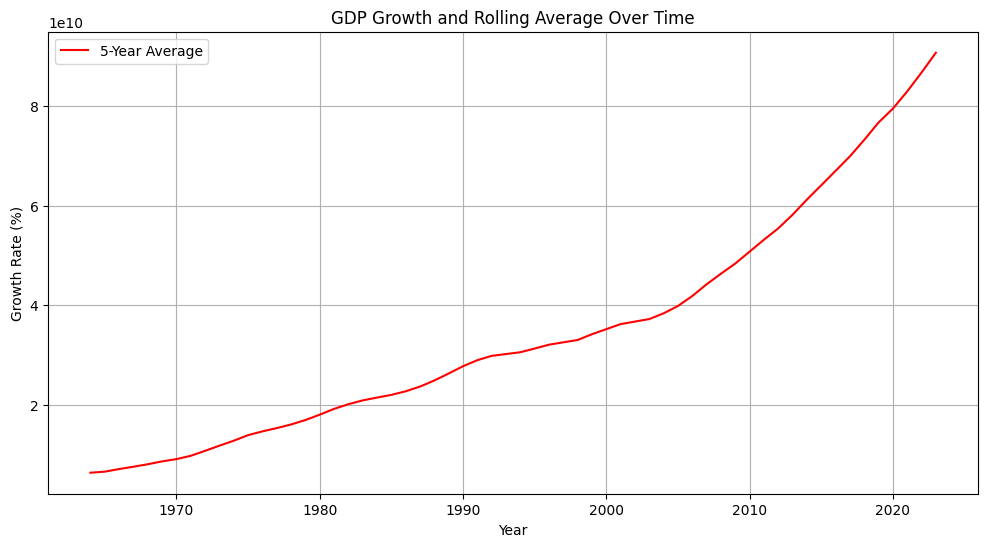

In [8]:


plt.figure(figsize=(12, 6))

plt.plot(df.index, df['Rolling GDP (5yr avg)'], color='red', label='5-Year Average')
plt.title('GDP Growth and Rolling Average Over Time')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


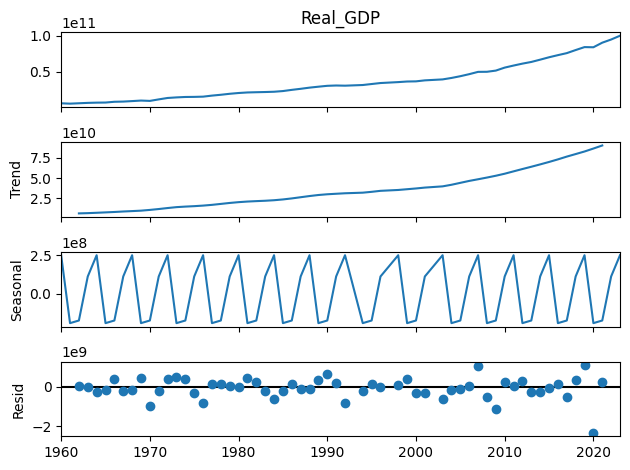

<Figure size 1500x1500 with 0 Axes>

In [9]:
decomp = seasonal_decompose(df['Real_GDP'], model='additive', period=4)
decomp.plot()

plt.figure(figsize=(15, 15))
plt.suptitle('Seasonal Decomposition')
plt.tight_layout()
plt.show()

In [10]:
# Stationarity Test
adf_result = adfuller(df['Real_GDP'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

ADF Statistic: 8.783962112036773
p-value: 1.0


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


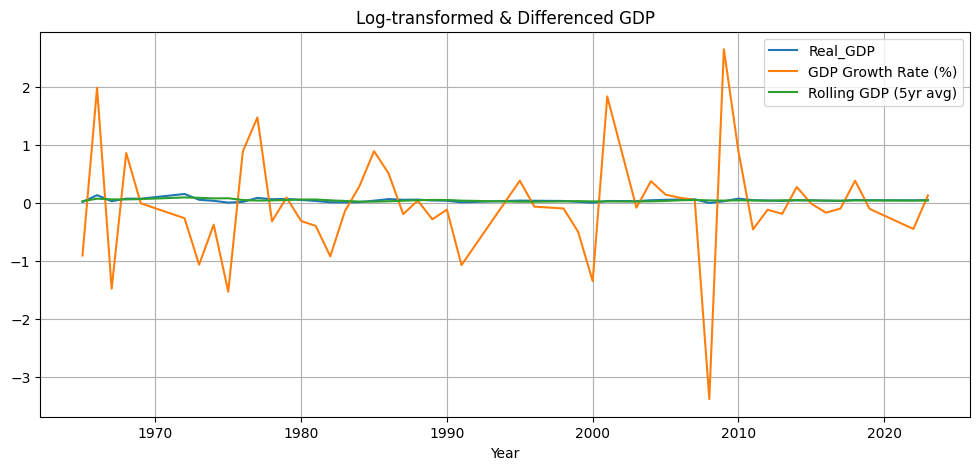

In [11]:
# Step 1: Log transform 
df_log = np.log(df)

# Step 2:  First -order differencing of the log-transformed data
df_log_diff = df_log.diff().dropna()

# Plot
df_log_diff.plot(figsize=(12, 5), title='Log-transformed & Differenced GDP')
plt.grid(True)
plt.show()

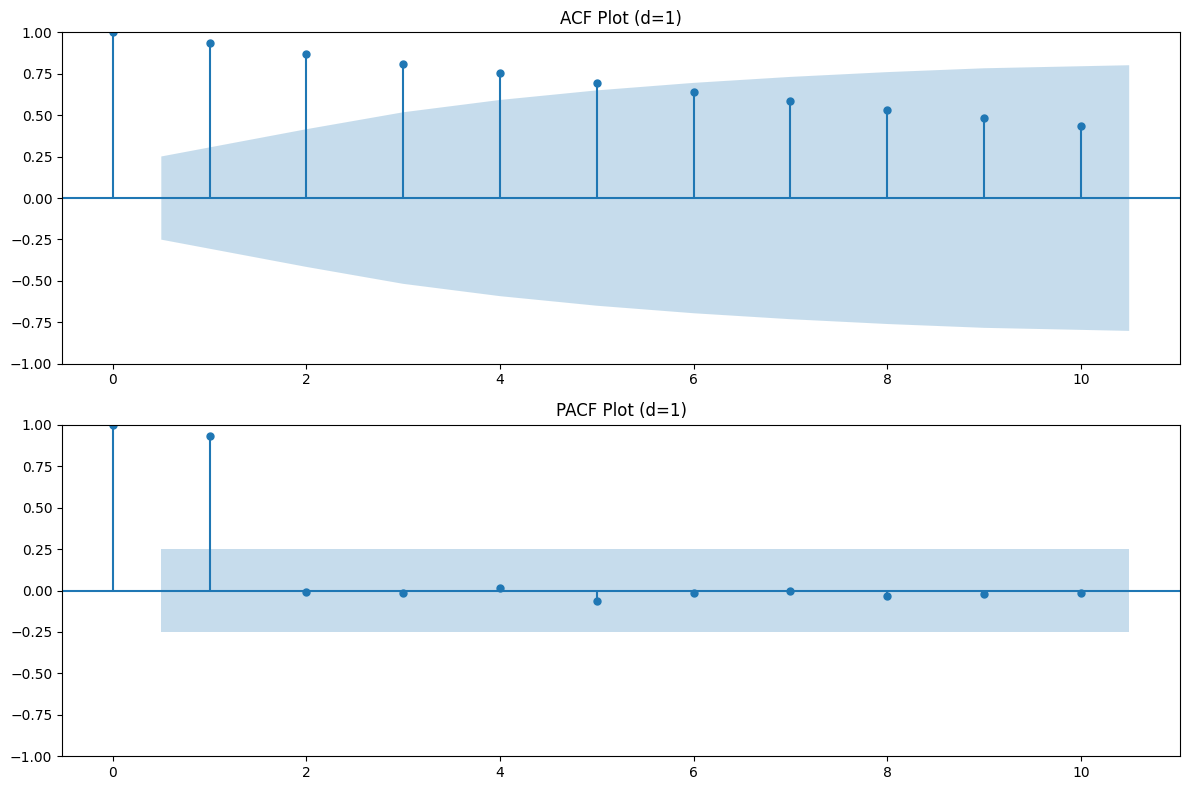

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt

# Select the GDP series
gdp_series = df['Real_GDP']  # Make sure 'Real_GDP' exists in your DataFrame

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(gdp_series, lags=10, ax=ax1, title='ACF Plot (d=1)')
plot_pacf(gdp_series, lags=10, ax=ax2, method='ywm', title='PACF Plot (d=1)')
plt.tight_layout()
plt.show()


13:37:18 - cmdstanpy - INFO - Chain [1] start processing
13:37:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


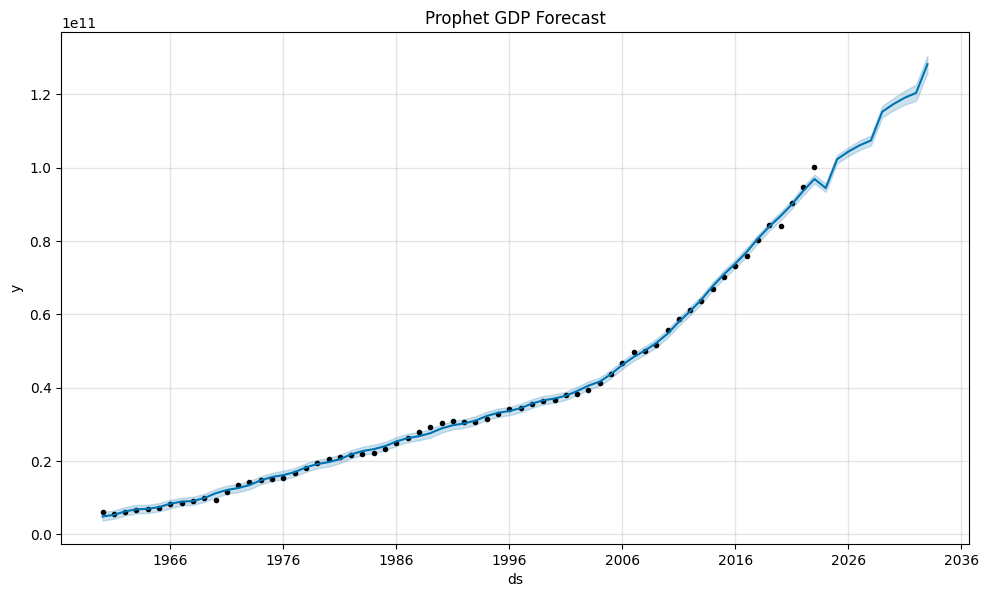

In [ ]:
from prophet import Prophet

df_prophet = df.reset_index().rename(columns={'Year': 'ds', 'Real_GDP': 'y'})
model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=10, freq='Y')
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title("Prophet GDP Forecast")
plt.show()

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Ensure correct data preparation
df_arima = df.copy()
df_arima.index = pd.to_datetime(df_arima.index)
df_arima['Real_GDP'] = pd.to_numeric(df_arima['Real_GDP'], errors='coerce')
df_arima.dropna(inplace=True)

# Step 1: ACF and PACF plots on differenced data
gdp_series = df_arima['Real_GDP'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(gdp_series, lags=10, ax=ax1, title='ACF Plot (Differenced GDP)')
plot_pacf(gdp_series, lags=10, ax=ax2, method='ywm', title='PACF Plot (Differenced GDP)')
plt.tight_layout()
plt.show()

# Step 2: Use auto_arima to find best (p,d,q)
auto_model = auto_arima(df_arima['Real_GDP'], seasonal=False, trace=True,
                        error_action='ignore', suppress_warnings=True, stepwise=True)

print(f"Selected ARIMA order: {auto_model.order}")

# Step 3: Fit ARIMA model with selected parameters
model = ARIMA(df_arima['Real_GDP'], order=auto_model.order)
model_fit = model.fit()

# Step 4: Forecast
forecast_years = 10
forecast = model_fit.forecast(steps=forecast_years)

# Step 5: Create future index and plot
future_index = pd.date_range(start=df_arima.index[-1] + pd.DateOffset(years=1),
                             periods=forecast_years, freq='Y')
forecast_series = pd.Series(forecast, index=future_index)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df_arima['Real_GDP'], label='Historical GDP')
plt.plot(forecast_series, label='ARIMA Forecast', linestyle='--')
plt.title('Kenya Real GDP Forecast using ARIMA')
plt.ylabel('GDP (constant 2015 US$)')
plt.xlabel('Year')
plt.grid(True)
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'pmdarima'